In [ ]:
🚌 Projet MDM - Mobilité Durable en Montagne ⛰️

Author : Laurent Sorba

Date : 23/06/2025

Description :

This Jupyter Notebook analyses the accessibility of the itineraries by measuring proximity to public transport stops, using pandas/geopandas to parse waypoints from the C2C CSV export for Isère `List_iti_D4G_isre.csv` and extract bus stop locations from a PostgreSQL SQL C2C dump  `UTF-8dump-c2corg-202505050900.sql.zip`. It performs spatial analysis to count itineraries within 0.5km–5km zones around bus stops using the EPSG:3857 coordinate system.

In [55]:
# Itinerary-Bus Stop Accessibility Analysis

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import re
import matplotlib.pyplot as plt
import binascii
import struct

# Set display options
pd.set_option('display.max_columns', None)

## 1. Load and Parse Itinerary Data from CSV

In [66]:
# Read CSV file
csv_path = '../data/C2C/Liste_iti_D4G_isere.csv'
df = pd.read_csv(csv_path, on_bad_lines='skip', low_memory=False)

# Display sample data
print("First 2 rows of original CSV:")
print(df.head(2).T)

First 2 rows of original CSV:
                                                                                                    0  \
Titre itinéraire                                    Les Bans:Spigolo Sud du Contrefort Médian. Voi...   
Id itinéraire                                                                                 1780070   
url                                                         https://www.camptocamp.org/routes/1780070   
activité                                                                            mountain_climbing   
durée                                                                                           ['1']   
dénivelé (m)                                                                                      NaN   
longueur (m)                                                                                      0.0   
Région/massif                                                         (14328 - Isère)(14403 - Écrins)   
Id wp principal          

## 2. Extract Waypoints from CSV

In [67]:
# Simplified pattern that focuses only on [X, Y] coordinates
coord_pattern = re.compile(r'\s*([+-]?\d+[\.\d]*)\s*,\s*([+-]?\d+[\.\d]*)\s*')

# List to store parsed waypoints
waypoints = []

# Identify waypoint columns (columns 9 onward)
waypoint_cols = df.columns[9:]

# Parse waypoints
for idx, row in df.iterrows():
    itinerary_id = row['Id itinéraire']

    for col in waypoint_cols:
        cell = str(row[col])
        if not cell or cell == 'nan':
            continue

        match = coord_pattern.search(cell)
        if match:
            try:
                x = float(match.group(1))
                y = float(match.group(2))

                waypoints.append({
                    'itinerary_id': itinerary_id,
                    'geometry': Point(x, y)
                })

            except (ValueError, TypeError):
                continue  # Skip invalid coordinates

# Create GeoDataFrame
if waypoints:
    wp_gdf = gpd.GeoDataFrame(
        pd.DataFrame(waypoints),
        geometry='geometry',
        crs='EPSG:3857'
    )
    print(f"\n✅ Successfully parsed {len(wp_gdf)} waypoints")
else:
    print("🚨 No coordinates found. Check if any cell contains [X, Y] format.")


✅ Successfully parsed 11917 waypoints


## 3. Load Bus Stop Data from PostgreSQL

In [69]:
from shapely.geometry import Point

def parse_sql_dump(sql_file):
    # Pattern to match INSERT statements
    insert_pattern = re.compile(r"INSERT INTO guidebook\.stopareas VALUES (.*?);", re.DOTALL)

    # List to store parsed stop areas
    stopareas = []

    with open(sql_file, 'r', encoding='utf-8') as f:
        content = f.read()

    # Process each INSERT statement
    for match in insert_pattern.finditer(content):
        values_str = match.group(1)

        # Split values preserving quoted strings (handling escaped quotes)
        values = []
        current = ""
        in_quote = False
        escape_next = False

        for char in values_str:
            if escape_next:
                current += char
                escape_next = False
                continue

            if char == '\\':
                escape_next = True
                continue

            # if char == '(':
            #     escape_next = True
            #     continue

            if char == "'":
                in_quote = not in_quote
                continue

            if char == ',' and not in_quote:
                values.append(current.strip())
                current = ""
                continue

            current += char

        if current.strip():
            values.append(current.strip())

        # Ensure we have enough values (at least 6)
        if len(values) < 6:
            continue

        try:
            # Extract basic fields
            stoparea_id = int(values[0].strip("("))
            navitia_id = values[1].strip("'")
            stoparea_name = values[2].strip("'")
            line = values[3].strip("'")
            operator = values[4].strip("'")
            ewkb_hex = values[5].strip("')")

            # Skip if geometry is NULL
            if ewkb_hex.upper() == 'NULL':
                continue

            # Convert hex to binary
            try:
                ewkb_bytes = binascii.unhexlify(ewkb_hex)
            except binascii.Error:
                continue

            # Check if we have enough data
            if len(ewkb_bytes) < 17:  # Minimum for point without SRID
                continue

            # Read byte order (1 = little, 0 = big)
            byte_order = ewkb_bytes[0]
            is_little_endian = byte_order == 1

            # Read geometry type (4 bytes)
            geom_type_bytes = ewkb_bytes[1:5]

            # Extract geometry type (first 4 bits) and flags
            if is_little_endian:
                geom_type = struct.unpack('<I', geom_type_bytes)[0]
            else:
                geom_type = struct.unpack('>I', geom_type_bytes)[0]

            # Check if this is a point (type = 1) - ignore flags
            if (geom_type & 0x07) != 1:  # Use bitmask to ignore SRID flag and others
                continue

            # Read SRID if present (bit 3 of geom_type is set)
            offset = 5
            srid = None
            if geom_type & 0x20000000:  # Check if SRID flag is set
                if len(ewkb_bytes) < 9:
                    continue
                if is_little_endian:
                    srid = struct.unpack('<I', ewkb_bytes[5:9])[0]
                else:
                    srid = struct.unpack('>I', ewkb_bytes[5:9])[0]
                offset = 9

            # Read coordinates
            if len(ewkb_bytes) < offset + 16:  # 8 bytes for x, 8 for y
                continue

            # Extract X and Y coordinates
            if is_little_endian:
                x = struct.unpack('<d', ewkb_bytes[offset:offset+8])[0]
                y = struct.unpack('<d', ewkb_bytes[offset+8:offset+16])[0]
            else:
                x = struct.unpack('>d', ewkb_bytes[offset:offset+8])[0]
                y = struct.unpack('>d', ewkb_bytes[offset+8:offset+16])[0]

            # Add to list
            stopareas.append({
                'stoparea_id': stoparea_id,
                'navitia_id': navitia_id,
                'stoparea_name': stoparea_name,
                'line': line,
                'operator': operator,
                'srid': srid,
                'geometry': Point(x, y)
            })

        except Exception as e:
            # Skip problematic rows
            continue

    # Create GeoDataFrame
    if stopareas:
        gdf = gpd.GeoDataFrame(stopareas, geometry='geometry', crs='EPSG:3857')
        return gdf
    else:
        return gpd.GeoDataFrame([])

In [70]:
# Load bus stops from SQL dump parsing
stops_gdf = parse_sql_dump('../data/C2C/dump-c2corg-202505050900.sql')
print(f"Loaded {len(stops_gdf)} bus stops from SQL dump")

print("First 5 bus stops:")
stops_gdf.head(5)

Loaded 1587 bus stops from SQL dump
First 5 bus stops:


,stoparea_id,navitia_id,stoparea_name,line,operator,srid,geometry
0,1,stop_area:OGE:GEN15846,"Le Haut-Bréda, Pinsot le Village (Le Haut-Bréda)",Bus 79 - ALLEVARD ECOLE PLEIADE,Mobilités M - TouGo,3857,POINT (679047.781 5677868.337)
1,2,stop_area:OGE:GEN15852,"Le Haut-Bréda, Hot Pic Belle Etoile (Le Haut-B...",Bus 79 - ALLEVARD ECOLE PLEIADE,Mobilités M - TouGo,3857,POINT (678910.858 5678497.283)
2,3,stop_area:OGE:GEN15850,"Le Haut-Bréda, Chinfert (Le Haut-Bréda)",Bus 79 - ALLEVARD ECOLE PLEIADE,Mobilités M - TouGo,3857,POINT (678788.406 5679655.482)
3,4,stop_area:OGE:GEN15080,"Le Haut-Bréda, la Piat (Le Haut-Bréda)",Bus 79 - ALLEVARD ECOLE PLEIADE,Mobilités M - TouGo,3857,POINT (678378.751 5675153.444)
4,5,stop_area:OGE:GEN13054,"Domène, Domène Mairie (Domène)",Bus 15 - GRENOBLE Verdun - Préfecture / DOMÈNE...,Mobilités M - Tag,3857,POINT (649900.998 5653440.123)


## 4. Spatial Analysis: Buffer Zones

In [64]:
# Define distances to test
distances = [500, 1000, 2000, 3000, 4000, 5000, 6000]  # in meters
results = {}

# Total itineraries in dataset
total_itineraries = df['Id itinéraire'].nunique()

# Analyze for each distance
for distance in distances:
    # Find waypoints within distance of any bus stop
    nearby = gpd.sjoin_nearest(
        wp_gdf,
        stops_gdf,
        how='left',
        max_distance=distance
    )

    # Get unique itineraries with at least one waypoint within distance
    accessible_ids = nearby[nearby['index_right'].notna()]['itinerary_id'].unique()
    count = len(accessible_ids)

    # Store results
    results[distance] = {
        'count': count,
        'percentage': (count / total_itineraries) * 100
    }

    print(f"\nWithin {distance}m: {count} itineraries ({results[distance]['percentage']:.1f}% of total)")


Within 500m: 1472 itineraries (33.4% of total)

Within 1000m: 2162 itineraries (49.1% of total)

Within 2000m: 2799 itineraries (63.6% of total)

Within 3000m: 3237 itineraries (73.6% of total)

Within 4000m: 3492 itineraries (79.3% of total)

Within 5000m: 3724 itineraries (84.6% of total)

Within 6000m: 3822 itineraries (86.8% of total)


## 5. Visualize Results

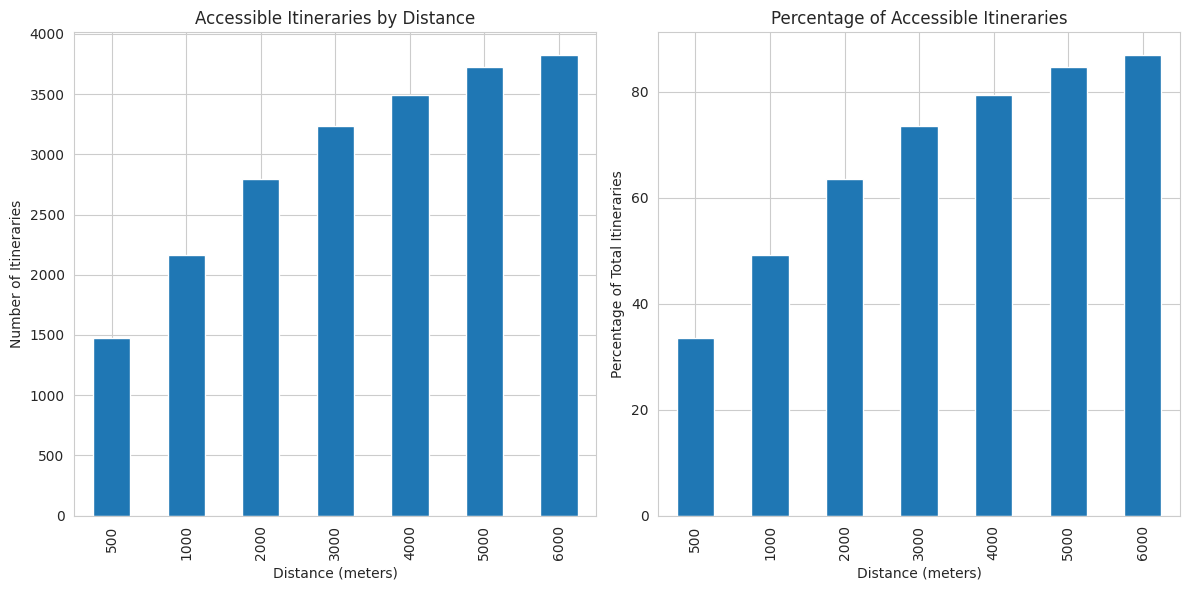

In [65]:
# Convert results to DataFrame
results_df = pd.DataFrame([
    {'distance': d, 'count': r['count'], 'percentage': r['percentage']}
    for d, r in results.items()
])

# Plot counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
results_df.set_index('distance')['count'].plot.bar()
plt.title('Accessible Itineraries by Distance')
plt.xlabel('Distance (meters)')
plt.ylabel('Number of Itineraries')

# Plot percentages
plt.subplot(1, 2, 2)
results_df.set_index('distance')['percentage'].plot.bar()
plt.title('Percentage of Accessible Itineraries')
plt.xlabel('Distance (meters)')
plt.ylabel('Percentage of Total Itineraries')

plt.tight_layout()
plt.show()

## 6. Export Results (Optional)

In [ ]:
# Export detailed results to CSV
results_df.to_csv('accessibility_results.csv', index=False)
print("Results saved to 'accessibility_results.csv'")